In [1]:
import torch
import torch.nn as nn

In [74]:
class Kernel(nn.Module):
    def __init__(self, hidden_dim):
        super(Kernel, self).__init__()

        self.gamma = nn.Parameter(torch.rand(hidden_dim))
        self.beta = nn.Parameter(torch.rand(hidden_dim))
        
    def forward(self, x):
        return (self.gamma * x + self.beta).square()

In [2]:
def normalize(x):
    mean = x.mean(dim=-1, keepdim=True)
    std = x.std(dim=-1, keepdim=True)
    return (x - mean) / (std + 1e-6)

In [3]:
def causal_dot_product(queries: torch.Tensor, keys: torch.Tensor, values: torch.Tensor) -> torch.Tensor:
    B, num_heads, T, head_size = queries.shape
    
    # Initialize the output tensor
    product = torch.zeros((B, num_heads, T, head_size), device=queries.device, dtype=queries.dtype)

    for b in range(B):
        for h in range(num_heads):
            kv = torch.zeros((head_size, head_size), device=queries.device, dtype=queries.dtype)  # Accumulator for key-value product
            for t in range(T):
                # Update kv with the outer product of keys and values
                kv += torch.outer(keys[b, h, t], values[b, h, t])  # Correctly compute outer product
                # Compute the dot product of the query and the accumulated kv
                product[b, h, t] = torch.matmul(queries[b, h, t], kv)

    return product


In [68]:
def default(kerq, kerk, v):

    T = v.size(2)
    mask = torch.tril(torch.ones(T, T)).view(1, 1, T, T)
    logits = kerq @ kerk.transpose(-2, -1)
    logits = logits.masked_fill(mask[:,:,:T,:T] == 0, 0)
    scores = logits / logits.sum(dim=-1, keepdim=True)
    out = scores @ v
    
    return out

def matrix(kerq, kerk, v):
    
    Z = 1/(torch.einsum("bhtf,bhtf->bht", kerq, kerk.cumsum(2)) + 1e-6)
    
    kv = torch.einsum('bhtf,bhtg->bhtfg', kerk, v).cumsum(dim=2)
    out = torch.einsum('bhtf,bhtfg->bhtg', kerq, kv)
    out = out * Z[:, :, :, None]
    
    return out

def looped(kerq, kerk, v):

    Z = 1/(torch.einsum("nlhi,nlhi->nlh", kerq, kerk.cumsum(2)) + 1e-6)
    
    B, num_heads, T, head_size = kerq.shape
    
    # Initialize the output tensor
    product = torch.zeros((B, num_heads, T, head_size))

    for b in range(B):
        for h in range(num_heads):
            kv = torch.zeros((head_size, head_size))  # Accumulator for key-value product
            for t in range(T):
                # Update kv with the outer product of keys and values
                kv += torch.outer(kerk[b, h, t], v[b, h, t])  # Correctly compute outer product
                # Compute the dot product of the query and the accumulated kv
                product[b, h, t] = torch.matmul(kerq[b, h, t], kv)
                
    out = product * Z[:,:,:,None]
    
    return out

In [75]:
import time
from tqdm.notebook import tqdm_notebook as tqdm
import gc

default_results = []
matrix_results = []
looped_results = []

hidden_dim = 32
attn_heads = 4

attn = nn.Linear(hidden_dim, 3 * hidden_dim)
linear = nn.Linear(hidden_dim, hidden_dim)
phiq = Kernel(hidden_dim)
phik = Kernel(hidden_dim)

ns = [1] + list(range(1000, 5000 + 1, 1000))

for n in tqdm(ns):
    with torch.no_grad():
        x = torch.rand(1, n, 32)
        
        B, T, C = x.size()

        qkv = attn(x)
        q, k, v = qkv.split(hidden_dim, dim=2)

        kerq = phiq(q)
        kerk = phik(k)

        kerq = kerq.view(B, T, attn_heads, C // attn_heads).transpose(1, 2)
        kerk = kerk.view(B, T, attn_heads, C // attn_heads).transpose(1, 2) 
        v = v.view(B, T, attn_heads, C // attn_heads).transpose(1, 2)

        # start = time.time()
        # default(kerq, kerk, v)
        # end = time.time()
        # default_results.append(end - start)

        start = time.time()
        matrix(kerq, kerk, v)
        end = time.time()
        matrix_results.append(end - start)
        
        start = time.time()
        looped(kerq, kerk, v)
        end = time.time()
        looped_results.append(end - start)
        
del x
gc.collect()

1315

In [19]:
sum([sum([p.numel() for p in module.parameters()]) for module in [attn, linear, phiq, phik]])

66560

In [76]:
(matrix(kerq, kerk, v) - looped(kerq, kerk, v)).norm()

tensor(5.9848e-05)

In [77]:
(matrix(kerq, kerk, v) - default(kerq, kerk, v)).norm()

tensor(9.7557e-05)

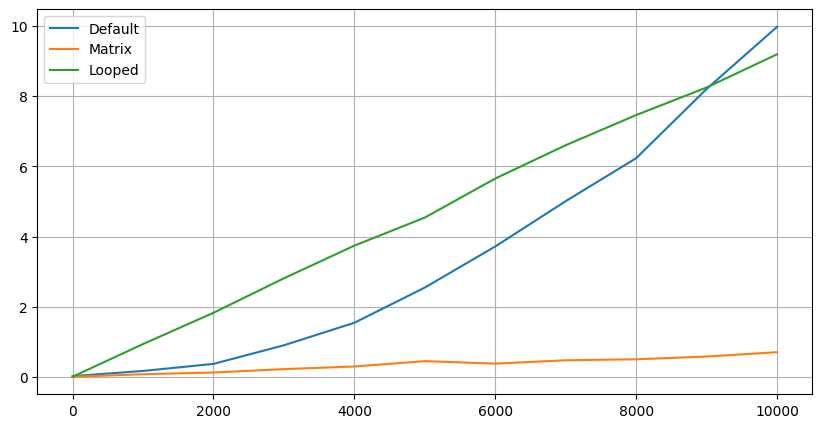

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.plot(ns, default_results, label = 'Default')
plt.plot(ns, matrix_results, label = 'Matrix')
plt.plot(ns, looped_results, label = 'Looped')
plt.grid()
plt.legend()
plt.show()